In [1]:
import os
import sys
import time
import h5py
import numpy as np
from glob import glob
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import verif_utils as vu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...] 

In [5]:
N_days = 300
grid_shape = lon_GFS.shape

q_bins_blend = np.arange(0.01, 1, 0.01)
N_bins = len(q_bins_blend)

name_NB = '/glade/campaign/cisl/aiml/ksha/NBlend_save/NB_025_2023_ini00_f{:02d}.hdf'
name_MRMS = '/glade/campaign/cisl/aiml/ksha/GFS/MRMS_6H_lead{:02d}_2023.hdf'

In [6]:
edge_left = 4
edge_right = -8
edge_bot = 2
edge_top = -1

grid_shape_cut = (grid_shape[0] - edge_bot + edge_top, grid_shape[1] - edge_left + edge_right)

In [13]:
CRPS_NB_lead = np.empty((N_days, grid_shape_cut[0], grid_shape_cut[1]))

#LEADs = [168,]
LEADs = np.arange(6, 168+6, 6)

for lead in LEADs:
    CRPS_NB_lead[...] = np.nan
    
    with h5py.File(name_NB.format(lead), 'r') as h5io:
        Y_PRED = h5io['Y_PRED'][:, :, edge_bot:edge_top, edge_left:edge_right]
    Y_PRED_flat = Y_PRED.reshape(N_days, N_bins, grid_shape_cut[0]*grid_shape_cut[1])
    
    with h5py.File(name_MRMS.format(lead), 'r') as h5io:
        MRMS_lead = h5io['MRMS_lead'][:, edge_bot:edge_top, edge_left:edge_right]
    MRMS_lead_flat = MRMS_lead.reshape(N_days, grid_shape_cut[0]*grid_shape_cut[1])
    
    for d in range(N_days):
        flag_nan = np.sum(np.isnan(MRMS_lead_flat[d, :])) + np.sum(np.isnan(Y_PRED_flat[d, :]))
        if flag_nan == 0:
            crps_ = vu.CRPS_1d_from_quantiles(q_bins_blend, Y_PRED_flat[d, ...], MRMS_lead_flat[d, :][None, ...])
            CRPS_NB_lead[d, ...] = crps_[0, :].reshape(grid_shape_cut[0], grid_shape_cut[1])
        else:
            CRPS_NB_lead[d, ...] = np.nan
    
    # save
    tuple_save = (CRPS_NB_lead,)
    label_save = ['CRPS_NB',]
    du.save_hdf5(tuple_save, label_save, '/glade/work/ksha/GAN_result/', 'NB_025_CRPS_2023_ini00_f{:02d}.hdf'.format(lead))

Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f06.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f12.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f18.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f24.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f30.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f36.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f42.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f48.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f54.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f60.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f66.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f72.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f78.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f84.hdf
Save to /glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f90

In [14]:
crps_NB_name = '/glade/work/ksha/GAN_result/NB_025_CRPS_2023_ini00_f{:02d}.hdf'
crps_climo_name = '/glade/work/ksha/GAN_result/CRPS_MRMS_6H_lead{:02d}_Climo_2023.hdf'
LEADs = np.arange(6, 168+6, 6)

CRPS_base_series = np.empty(len(LEADs))
CRPS_climo = np.empty(len(LEADs))

for l, lead in enumerate(LEADs): 
    
    with h5py.File(crps_NB_name.format(lead), 'r') as h5io:
        crps_ = h5io['CRPS_NB'][...]
    CRPS_base_series[l] = np.nanmean(crps_)
    
    with h5py.File(crps_climo_name.format(lead), 'r') as h5io:
        crps_ = h5io['CRPS_climo_lead'][...]
    CRPS_climo[l] = np.nanmean(crps_)
    
# tuple_save = (CRPS_climo_lead,)
# label_save = ['CRPS_climo_lead',]
# du.save_hdf5(tuple_save, label_save, result_dir, 'CRPS_MRMS_6H_lead{:02d}_Climo_2023.hdf'.format(lead))

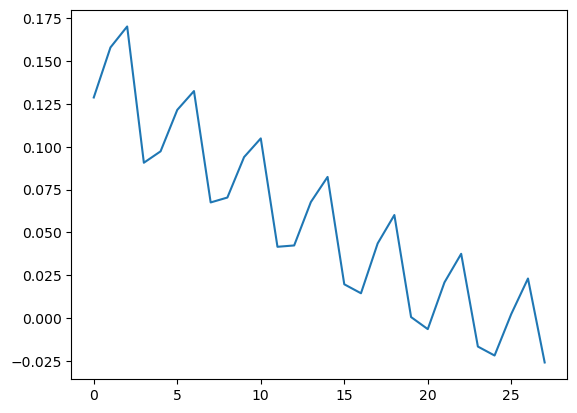

In [15]:
plt.plot(1-CRPS_base_series/CRPS_climo)
#plt.plot()

## Debug

In [83]:
with h5py.File(name_MRMS.format(6), 'r') as h5io:
    MRMS_lead6 = h5io['MRMS_lead'][:, edge_bot:edge_top, edge_left:edge_right]

with h5py.File(name_MRMS.format(30), 'r') as h5io:
    MRMS_lead30 = h5io['MRMS_lead'][:, edge_bot:edge_top, edge_left:edge_right]

In [ ]:
with h5py.File(crps_base_name.format(6), 'r') as h5io:
    crps_6 = h5io['CRPS_NB'][...]

with h5py.File(name_NB.format(6), 'r') as h5io:
    Y_PRED_6 = h5io['Y_PRED'][:, :, edge_bot:edge_top, edge_left:edge_right]

In [ ]:
with h5py.File(crps_base_name.format(30), 'r') as h5io:
    crps_30 = h5io['CRPS_NB'][...]

with h5py.File(name_NB.format(30), 'r') as h5io:
    Y_PRED_30 = h5io['Y_PRED'][:, :, edge_bot:edge_top, edge_left:edge_right]

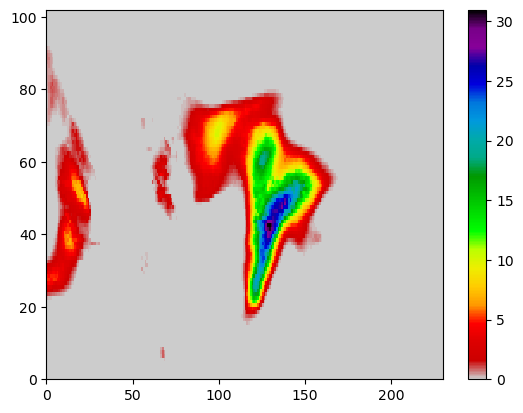

In [115]:
# plt.pcolormesh(crps_6[2, ...], cmap=plt.cm.nipy_spectral_r)
# plt.colorbar()
plt.pcolormesh(Y_PRED_6[2, 50, ...], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

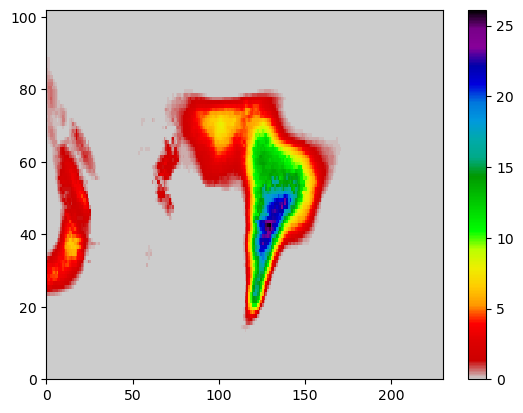

In [117]:
plt.pcolormesh(Y_PRED_30[1, 50, ...], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

In [104]:
for i in range(10):
    print('{} - {}'.format(np.nansum(crps_6[i+1, ...]), np.nansum(crps_30[i, ...])))

3574.6591224154226 - 3943.637597088839
16158.19477954102 - 14417.876151197597
5424.51627705713 - 4761.078526688425
14818.9056732457 - 14777.525683080097
3489.297891022436 - 3698.547181701005
1367.5541310961924 - 2012.4561545202475
4922.125072566141 - 4541.7314315045
3018.3386239328365 - 2335.2289079178818
5781.532947802487 - 5121.368139077515
2766.098626498624 - 2351.770647641591
